In [2]:
import tweepy
import csv
import pandas as pd
import json

from nltk.corpus import stopwords, reuters
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
import datetime
from ibm_watson import ToneAnalyzerV3
from pandas import json_normalize
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from dotenv import load_dotenv

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

all_tweets = []

In [3]:
def load_vaccine_csv():
    df = pd.read_csv('./Resources/covidvaccine.csv')
    df = df[['user_name','user_location','user_followers',	'user_friends',	'user_favourites',	'user_verified',	'date',	'text',	'source']]
    
    # '18-08-2020 12:55'
    # df.index = pd.to_datetime(df['date'])
    # for managebility we remove the hashtag, but it might have a future use-case
    # is_retweet is all False in this dataset
    # df = df[df['is_retweet'] == False]
    # df = df.dropna()
    return df

In [4]:
def try_parse(dateString):
    """ Try and parse a Date string in 4 different formats
    Parameter
    ----------
    dateString : string

    Returns
    ----------
    date : date
    """
    # return dateString
    # print(dateString)
    try:
        return datetime.datetime.strptime(dateString, '%Y-%m-%d %H:%M:%S')
    except Exception as e:
        try:
            return datetime.datetime.strptime(dateString, '%Y-%m-%d %H:%M')
        except Exception as e:
            try:
                return datetime.datetime.strptime(dateString, '%d-%m-%Y %H:%M')
            except Exception as e:
                return datetime.datetime.strptime(dateString, '%d-%m-%Y %H:%M:%S')


In [5]:

df = load_vaccine_csv()

#18-08-2020 12:55
df = df[df.date.notnull()]
df = df[df.date.str.contains("-")]

df['date'] = df['date'].apply(lambda t: try_parse(t))
df['xxx'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

df = df.sort_index()
df

,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,source,xxx
0,MyNewsNE,Assam,64.0,11,110,False,2020-08-18 12:55:00,Australia to Manufacture Covid-19 Vaccine and ...,Twitter Web App,2020-08-18 12:55:00
1,Shubham Gupta,NaN,1.0,17,0,False,2020-08-18 12:55:00,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,Twitter for Android,2020-08-18 12:55:00
2,Journal of Infectiology,NaN,143.0,566,8,False,2020-08-18 12:46:00,Deaths due to COVID-19 in Affected Countries\n...,Twitter Web App,2020-08-18 12:46:00
3,Zane,NaN,29.0,25,620,False,2020-08-18 12:45:00,@Team_Subhashree @subhashreesotwe @iamrajchoco...,Twitter for Android,2020-08-18 12:45:00
4,Ann-Maree O’Connor,"Adelaide, South Australia",83.0,497,10737,False,2020-08-18 12:45:00,@michellegrattan @ConversationEDU This is what...,Twitter Web App,2020-08-18 12:45:00
...,...,...,...,...,...,...,...,...,...,...
354385,pinakbet808,"San Francisco, CA",0.0,83,0,False,2021-02-15 00:01:02,I called my lola to wish her a Happy Valentine...,Twitter for iPhone,2021-02-15 00:01:02
354386,UCAN Indonesia,Jakarta,2954.0,1023,2,False,2021-02-15 00:00:56,Cambodia’s Ministry of Health approves emergen...,SocialPilot.co,2021-02-15 00:00:56
354387,UCAN India,India,1771.0,270,65,False,2021-02-15 00:00:56,Cambodia’s Ministry of Health approves emergen...,SocialPilot.co,2021-02-15 00:00:56
354388,VaccinatePA,Pennsylvania,1191.0,44,44,False,2021-02-15 00:00:09,"Thanks for helping us get the word out, @abc27...",Twitter Web App,2021-02-15 00:00:09


In [6]:
df2 = df.dropna()
df2

,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,source,xxx
0,MyNewsNE,Assam,64.0,11,110,False,2020-08-18 12:55:00,Australia to Manufacture Covid-19 Vaccine and ...,Twitter Web App,2020-08-18 12:55:00
4,Ann-Maree O’Connor,"Adelaide, South Australia",83.0,497,10737,False,2020-08-18 12:45:00,@michellegrattan @ConversationEDU This is what...,Twitter Web App,2020-08-18 12:45:00
6,Rajesh Tadepalli,"Hyderabad, India",918.0,2561,31837,False,2020-08-18 12:34:00,@PrivilRodrigues @yatish57 @deepkaranahuja @sh...,Twitter for Android,2020-08-18 12:34:00
7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,2321.0,3236,264351,False,2020-08-18 12:30:00,"@MSNBC Well, let’s qualify that: would anyone ...",Twitter for iPhone,2020-08-18 12:30:00
8,Dr. Joseph Santoro,"Washington, DC 20009",19091.0,20986,128119,False,2020-08-18 12:15:00,"Most countries, without the ability to make #V...",Hootsuite Inc.,2020-08-18 12:15:00
...,...,...,...,...,...,...,...,...,...,...
354384,Dr Mahendra G Patel We-are-ALL-AT-RISK #COVID19,"Yorkshire and The Humber, England",5245.0,1296,25625,False,2021-02-15 00:03:11,After weeks away now dipping in lightly &amp; ...,Twitter for iPhone,2021-02-15 00:03:11
354385,pinakbet808,"San Francisco, CA",0.0,83,0,False,2021-02-15 00:01:02,I called my lola to wish her a Happy Valentine...,Twitter for iPhone,2021-02-15 00:01:02
354386,UCAN Indonesia,Jakarta,2954.0,1023,2,False,2021-02-15 00:00:56,Cambodia’s Ministry of Health approves emergen...,SocialPilot.co,2021-02-15 00:00:56
354387,UCAN India,India,1771.0,270,65,False,2021-02-15 00:00:56,Cambodia’s Ministry of Health approves emergen...,SocialPilot.co,2021-02-15 00:00:56


In [7]:
load_vaccine_csv().dtypes


user_name           object
user_location       object
user_followers     float64
user_friends        object
user_favourites     object
user_verified       object
date                object
text                object
source              object
dtype: object

In [8]:

df.describe()


,user_followers
count,1.374770e+05
mean,5.157729e+04
std,6.479442e+05
min,0.000000e+00
25%,1.390000e+02
50%,6.030000e+02
75%,2.664000e+03
max,1.474791e+07


In [9]:
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nimendrapethiyagoda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def process_text(doc):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', doc)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw]
    return ' '.join(output)

In [11]:
def analyse_sentiment(df):
    load_dotenv()
    tone_api = os.getenv("TONE_ANALYZER_APIKEY")
    tone_url = os.getenv("TONE_ANALYZER_URL")
    authenticator = IAMAuthenticator(tone_api)
    tone_analyzer = ToneAnalyzerV3(
        version="2017-09-21",
        authenticator=authenticator
    )

    utterances = [{"text": u, "user": "guest"} for u in df['text'].to_numpy()]

    # Analyze utterances using the 'tone_chat()' method
    utterance_analysis = tone_analyzer.tone_chat(
        utterances=utterances, content_language="en", accept_language="en"
    ).get_result()
    # print(json.dumps(utterance_analysis, indent=2))
    chat_tone_df = json_normalize(
        data=utterance_analysis["utterances_tone"],
        record_path=["tones"],
        meta=["utterance_id", "utterance_text"],
    )
    return chat_tone_df

In [12]:
def analyse_sentimemnt_vader(df):   
    sentiments = []

    for index, row in df.iterrows():
        try:
            text = row["text"]
            # date = article["publishedAt"][:10]
            sentiment = analyzer.polarity_scores(text)
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]
            
            sentiments.append({
                "text": text,
                "date": row['date'],
                "user_location":row['user_location'],
                "user_followers":row['user_followers'],
                "user_friends":row['user_friends'],
                "user_favourites":row['user_favourites'],
                "user_name": row['user_name'],
                "user_verified": row['user_verified'],
                "source": row['source'],
                "compound": compound,
                "positive": pos,
                "negative": neg,
                "neutral": neu
                
            })
            
        except AttributeError:
            pass
        
    # Create DataFrame
    ret_df = pd.DataFrame(sentiments)

    # Reorder DataFrame columns
    cols = ["date","user_name", "user_location","user_followers", "user_friends", "user_favourites", "text", "compound", "positive", "negative", "neutral", "user_verified", "source"]
    ret_df = ret_df[cols]
    ret_df.set_index('date', inplace=True)
    ret_df = ret_df.sort_index()

    return ret_df

In [13]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
tweet_tone_df = analyse_sentimemnt_vader(df2)
tweet_tone_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nimendrapethiyagoda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,user_name,user_location,user_followers,user_friends,user_favourites,text,compound,positive,negative,neutral,user_verified,source
date,,,,,,,,,,,,
2020-08-09 19:15:00,Ashwin,India 🇮🇳,89.0,3108,6780,Huge Thanks And Best Wishes With @SerumInstInd...,0.9169,0.517,0.000,0.483,False,Twitter for Android
2020-08-09 20:02:00,K. Kartik Rao,Mumbai and Nagpur India,225.0,257,25362,Any update of #CovidVaccine ????,0.0000,0.000,0.000,1.000,False,Twitter for Android
2020-08-09 21:21:00,Mac Patrick (Road Hater) Henry,German Bundesrepublik,338.0,277,28305,From a private frontline COVID nurses group to...,0.0000,0.000,0.000,1.000,False,Twitter Web App
2020-08-09 21:29:00,lydia Bell,Earth,2038.0,1105,63422,So you want the whole world to take a #covidva...,0.0745,0.058,0.000,0.942,False,Twitter for iPhone
2020-08-09 22:55:00,Lou Ann Donovan,"Kansas, USA",4365.0,4581,2505,Watch to learn about the Phase 3 clinical tria...,0.0000,0.000,0.000,1.000,False,Twitter for iPhone
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-18 23:58:25,Jules Doyle,Chicago,799.0,2467,112893,The #nightlynews is essentially 30 minutes of ...,-0.2263,0.000,0.101,0.899,False,Twitter for iPhone
2021-02-18 23:58:41,Bradley Mathys,"Montréal, Québec",18.0,143,160,Woohoo! First dose of Moderna is done. Feels g...,0.7772,0.430,0.000,0.570,False,Twitter for Android
2021-02-18 23:59:37,sir crankypants,"South Carolina, USA",215.0,617,8905,"""I don't want to be a guinea pig, my life's to...",0.1476,0.078,0.053,0.869,False,Twitter for Android


In [14]:
from geopy.geocoders import Nominatim
app = Nominatim(user_agent="JournalDev")
location = app.geocode("Austin, Texas")
location

Location(Austin, Travis County, Texas, United States, (30.2711286, -97.7436995, 0.0))

In [15]:
# Pfizer Stock data, in 15 min intervals
pfizer_df = pd.read_csv('./Resources/Pfizer.csv', parse_dates=True, index_col='time',)
pfizer_df.index.names = ['date']
pfizer_df


,open,high,low,close,volume
date,,,,,
2020-07-31 04:15:00,35.984022,35.984022,35.984022,35.984022,215
2020-07-31 05:00:00,35.984022,35.984022,35.984022,35.984022,105
2020-07-31 05:15:00,36.002599,36.002599,36.002599,36.002599,217
2020-07-31 05:30:00,36.104774,36.188371,36.039754,36.039754,1850
2020-07-31 06:00:00,36.132640,36.132640,36.132640,36.132640,196
...,...,...,...,...,...
2021-02-25 19:00:00,33.760000,33.769900,33.740000,33.750000,1945
2021-02-25 19:15:00,33.730000,33.750000,33.710000,33.710000,5680
2021-02-25 19:30:00,33.710000,33.720100,33.710000,33.710000,6066


In [16]:

tweet_tone_with_dummies_df = pd.get_dummies(tweet_tone_df, columns=['source'])
tweet_tone_with_dummies_df['verified'] = tweet_tone_with_dummies_df['user_verified'].apply(lambda x: 1 if (x == True) else 0)
tweet_tone_with_dummies_resampled_df = tweet_tone_with_dummies_df.resample('15min').sum()
combined_df = pd.concat([tweet_tone_with_dummies_resampled_df, pfizer_df], axis=1, join='inner')
combined_df


,user_followers,compound,positive,negative,neutral,source_92 News HD,source_@healthpolicyw,source_A Touch of Snark,source_Africa Newsroom,source_AgoraPulse Manager,...,source_iOS,source_recurpost.com,source_robly_marketing,source_syllogiTweeter,verified,open,high,low,close,volume
date,,,,,,,,,,,,,,,,,,,,,
2020-08-10 05:30:00,0.0,0.0000,0.000,0.000,0.000,0,0,0,0,0,...,0,0,0,0,0,35.733230,35.733230,35.733230,35.733230,386
2020-08-10 07:15:00,0.0,0.0000,0.000,0.000,0.000,0,0,0,0,0,...,0,0,0,0,0,35.853982,35.872559,35.761096,35.872559,1719
2020-08-10 07:30:00,0.0,0.0000,0.000,0.000,0.000,0,0,0,0,0,...,0,0,0,0,0,35.770384,35.770384,35.770384,35.770384,210
2020-08-10 07:45:00,548972.0,-0.3612,0.000,0.161,1.839,0,0,0,0,0,...,0,0,0,0,1,35.761096,35.779673,35.761096,35.779673,2073
2020-08-10 08:00:00,669.0,0.3400,0.165,0.101,2.734,0,0,0,0,0,...,0,0,0,0,0,35.807539,35.807539,35.761096,35.761096,1618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-18 19:00:00,274209.0,3.9705,3.894,1.548,34.558,0,0,0,0,0,...,0,0,0,0,0,34.540000,34.560000,34.510000,34.510000,22236
2021-02-18 19:15:00,660176.0,-0.0226,1.402,1.440,21.157,0,0,0,0,0,...,0,0,0,0,0,34.540000,34.540000,34.510000,34.520000,6693
2021-02-18 19:30:00,223090.0,6.1219,3.163,1.052,29.785,0,0,0,0,0,...,0,0,0,0,0,34.510000,34.540000,34.510000,34.530000,6108


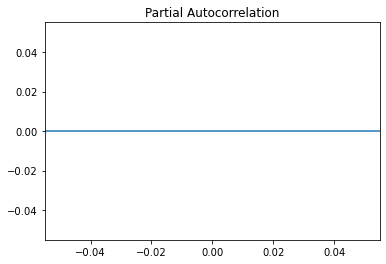

In [17]:
c = combined_df.corr()
# ax = sns.heatmap(flights.corr(), annot=True) 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
combined_df['pct'] = combined_df['close'].pct_change()
# combined_df
plot_pacf(combined_df['pct'], lags=10, zero=False);
# combined_df['pct'].plot()

In [18]:
import seaborn as sns 

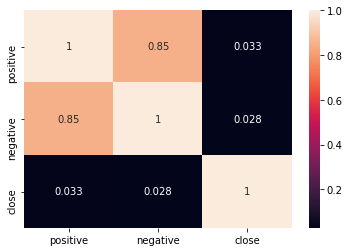

In [19]:
# combined_df
corr_df = combined_df[['positive','negative','close']]

# 1. replace close with pctChange Up/Down 1 or -1
# 2. scale all other columns to betweeb 0 and 1
# 3. start with 1 lag 15 mins

# 4. Train models on that - Okena, Sam, Paul, Raj
# 5. Wordcloud - Nimo


ax = sns.heatmap(corr_df.corr(), annot=True) 

In [20]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [21]:
corr_df = [crosscorr(tweet_tone_with_dummies_df['positive'], pfizer_df['close'].pct_change(), lag=i) for i in range(12)]
#  corr_df
corr_df
# ax = sns.heatmap(corr_df, annot=True) 

[0.026252393107372114,
 -0.017207200914962435,
 0.07306378863452806,
 -0.06476196174447098,
 0.02754556984140993,
 -0.010265409178510737,
 -0.06004254260235032,
 -0.04832726578221767,
 0.008862422490055108,
 -0.0216029955284507,
 -0.029922218776448222,
 0.030282478157341745]

## Lag of 2 seems to be best

In [24]:
# Shifting tweets by 2 (30 mins) because that seems to correlate best with stock prices
shifted_tweet_tone_df = tweet_tone_df.shift(2).dropna()
shifted_tweet_tone_df

,user_name,user_location,user_followers,user_friends,user_favourites,text,compound,positive,negative,neutral,user_verified,source
date,,,,,,,,,,,,
2020-08-09 21:21:00,Ashwin,India 🇮🇳,89.0,3108,6780,Huge Thanks And Best Wishes With @SerumInstInd...,0.9169,0.517,0.000,0.483,False,Twitter for Android
2020-08-09 21:29:00,K. Kartik Rao,Mumbai and Nagpur India,225.0,257,25362,Any update of #CovidVaccine ????,0.0000,0.000,0.000,1.000,False,Twitter for Android
2020-08-09 22:55:00,Mac Patrick (Road Hater) Henry,German Bundesrepublik,338.0,277,28305,From a private frontline COVID nurses group to...,0.0000,0.000,0.000,1.000,False,Twitter Web App
2020-08-10 00:15:00,lydia Bell,Earth,2038.0,1105,63422,So you want the whole world to take a #covidva...,0.0745,0.058,0.000,0.942,False,Twitter for iPhone
2020-08-10 02:56:00,Lou Ann Donovan,"Kansas, USA",4365.0,4581,2505,Watch to learn about the Phase 3 clinical tria...,0.0000,0.000,0.000,1.000,False,Twitter for iPhone
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-18 23:58:25,Kathleen Coughlin,"San Diego, CA",188.0,315,1668,Of course they did❗️ \n\n#SoulsToThePolls\n#Bl...,0.0000,0.000,0.000,1.000,False,Twitter for iPhone
2021-02-18 23:58:41,Rob Weisman,Boston,3678.0,780,574,Feds tell MA officials #COVIDVaccine shipments...,-0.2263,0.000,0.128,0.872,False,Twitter Web App
2021-02-18 23:59:37,Jules Doyle,Chicago,799.0,2467,112893,The #nightlynews is essentially 30 minutes of ...,-0.2263,0.000,0.101,0.899,False,Twitter for iPhone
